# Introduction to Neural Nets

This Colab notebook builds a deep neural network to perform regression.
The goal will be to approximate the unknown function $f$ such that $\bm{y}=f(\bm{x})$, which relates the inputs $\bm{x}$ with the targets $\bm{y}$, using the training data $\mathcal{D}_{\mathrm{train}} = \left\{ \bm{x}^{(i)}, \bm{y}^{(i)} \right\}_{i=1}^{N_{\mathrm{train}}}$. 

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Create a simple deep neural network.
  * Tune the hyperparameters for a simple deep neural network.
  * Perform simple regression tasks using a training dataset. 
  * We will use some of these concepts and elements throughout the tutorial today. 

#### Import relevant modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

print("PyTorch version: ", torch.__version__)
print("Imported moduules successfully")


PyTorch version:  2.5.1
Imported moduules successfully


#### Dataset -- Training and testing data

The following code cell creates the training and testing data. 

In [3]:
# Target function
def target_function(x):
    # rosenbrock function
    # return ((0.5 - x[:,0]) ** 2 + 2.5 * (x[:,1] - x[:,0] ** 2) ** 2) / 10.
    # sinusoidal function
    return np.cos(np.pi * x[:,0]) * np.cos(np.pi * x[:,1]) #Computes cos(pi*x) x cos(y*pi) for each row in x, and returns the result

# Function to create training and test data
def generate_data(n_train, n_test):
    np.random.seed(0)
    X = np.random.uniform(-1, 1, size=(n_train + n_test, 2))
    Y = target_function(X)
    return X[:n_train], Y[:n_train], X[n_train:], Y[n_train:]

n_train = 200
n_test = 50
train_x, train_y, test_x, test_y = generate_data(n_train, n_test)


The following hidden code cell shows the target function and the training data points. 

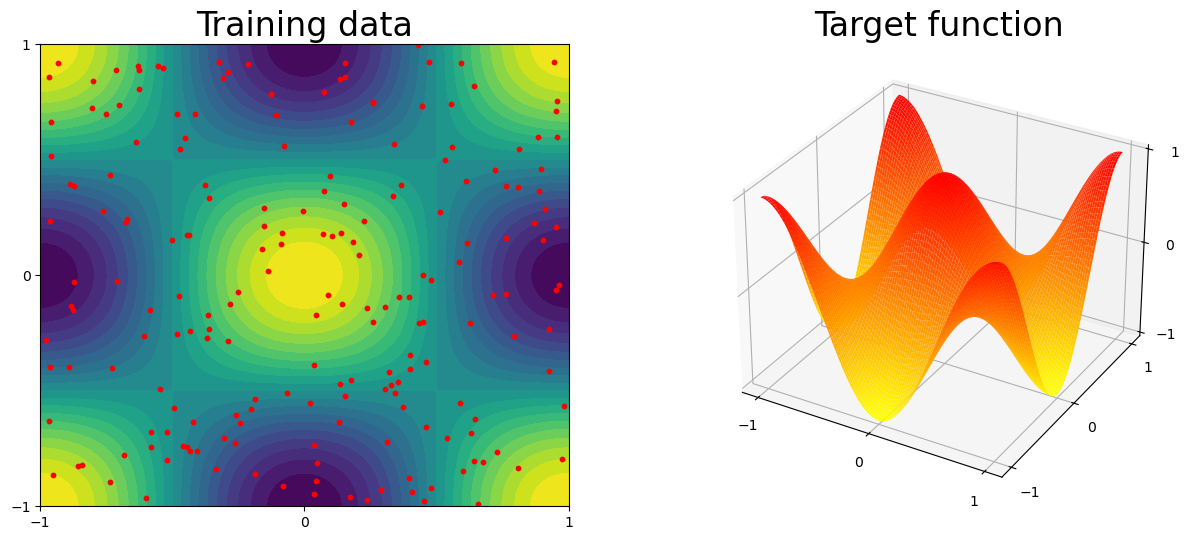

In [4]:
#Plot the target function.
X_mesh, Y_mesh = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
Z = target_function(np.hstack([X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)])).reshape(100, 100)
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,2,1)
ax.contourf(X_mesh, Y_mesh, Z, 20)
ax.scatter(train_x[:,0], train_x[:,1], c='r', s=10)
ax.set_title(r'Training data', fontsize=24)
ax.xaxis.set_ticks([-1, 0, 1])
ax.yaxis.set_ticks([-1, 0, 1])
ax = fig.add_subplot(1,2,2, projection="3d")
ax.plot_surface(X_mesh, Y_mesh, Z, cmap="autumn_r", lw=0.5, rstride=1, cstride=1)
ax.set_title(r'Target function', fontsize=24)
ax.xaxis.set_ticks([-1, 0, 1])
ax.yaxis.set_ticks([-1, 0, 1])
ax.zaxis.set_ticks([-1, 0, 1])
plt.show()

#### Neural network -- Creation and initialization

The following code cell:
* Creates a function which returns fully-connected neural network based on the user-specified width, depth and activation type.
* Initializes the neural network for training. 

In [9]:
class NeuralNetwork(torch.nn.Module): #NeuralNetwork is the name we are giving our class, torch.nn.Module is the inheritence/parent class
    def __init__(self, input_dim=2, output_dim=1, width=5, depth=3, activation='relu'): #The first thing that is run in the NeuralNetwork class 
        super().__init__()           #This is the constructor for the class - sets up variables, objects, whatever is defined in the parent class
        self.input_dim = input_dim          # input dimension, stores the values as part of the object 
        self.output_dim = output_dim        # output dimension
        self.width = width                  # width of hidden layers
        self.depth = depth                  # number of hidden layers + output layer
        if activation == 'relu':       #Set the activation function 
            self.activation = torch.nn.ReLU()
        elif activation == 'tanh':
            self.activation = torch.nn.Tanh()
        else:
            raise ValueError('activation must be one of "relu", "tanh", or "sin"')
        
        self.modules = [] #Empty list to hold all the layers of the network
        self.modules.append(torch.nn.Linear(input_dim, width))  # input layer - takes 'input_dim' inputs, and outputs 'width' number of outputs 
        self.modules.append(self.activation)                    # activation function
        for _ in range(depth-1):                                # the _ means that the iteration variable, say i, is not needed in the loop
            self.modules.append(torch.nn.Linear(width, width))  # add hidden layers
            self.modules.append(self.activation)                # activation function
        
        self.modules.append(torch.nn.Linear(width, output_dim)) # output layer, takes in 'width' inputs and outputs 'output_dim' number of outputs
        self.net = torch.nn.Sequential(*self.modules)           # combines all layers, * unpacks the list ie. if layers = [layer1, layer2, layer3], then 
                                                                # (*layers) is the same thing as passing in (layer1, layer2, layer3) manually

    def forward(self, x): 
        return self.net(x)



#### Training and testing functions

The following code cell:
* develops a function that trains a neural network.
* develops a function that tests the neural network. 

In [7]:
def train_network(net, train_loader, test_loader, epochs, optim, loss_fn, verbose=True):
    train_loss = []  # store training loss
    test_loss = []   # store test loss
    train_loss.append(test_network(net, train_loader, loss_fn))     # evaluate loss on training data before training the network
    test_loss.append(test_network(net, test_loader, loss_fn))       # evaluate loss on test data before training the network
    net.train()
    for epoch in range(epochs):                                     # loop over the dataset multiple times
        for x, y in train_loader:                                   # loop over each mini-batch
            optim.zero_grad()                                       # zero the parameter gradients
            y_pred = net(x)                                         # forward pass
            loss = loss_fn(y_pred, y.unsqueeze(1))                  # compute loss
            loss.backward()                                         # backward pass
            optim.step()                                            # update weights
        if epoch % 100 == 0:                                        # print loss every 100 epochs
            test_loss_ = test_network(net, test_loader, loss_fn)     # evaluate loss on test data
            train_loss_ = test_network(net, train_loader, loss_fn)   # evaluate loss on training data
            train_loss.append(train_loss_)                           # store training loss
            test_loss.append(test_loss_)                             # store test loss
            if verbose:                                         
                print(f'Epoch {epoch}, Train Loss {train_loss_:.3f}, Test Loss {test_loss_:.3f}') # print loss
            

    # Evaluate loss on training and test data after training the network
    train_loss.append(test_network(net, train_loader, loss_fn))
    test_loss.append(test_network(net, test_loader, loss_fn))
    return net, train_loss, test_loss # return trained network and loss

def test_network(net, test_loader, loss_fn):
    net.eval()                                                  # set the network to evaluation mode (deactivates dropout and batch normalization)
    with torch.no_grad():                                       # deactivate autograd engine (reduce memory consumption)
        loss = 0.                                               # initialize loss
        for x, y in test_loader:                                # loop over each mini-batch
            y_pred = net(x)                                     # forward pass
            loss += loss_fn(y_pred, y.unsqueeze(1)).item()      # compute loss
    net.train()                                                 # set the network back to training mode
    return loss / len(test_loader)                              # return average loss

#### Neural network -- Training and evaluation/testing

The following code cell:
* specifies learning and model hyper-parameters for the neural network.
* sets up training and testing dataloader objects
* specifies loss function and optimizer for training
* trains the neural network
* plots the loss curve

Total number of parameters: 1031
Epoch 0, Train Loss 6.278, Test Loss 6.920
Epoch 100, Train Loss 4.609, Test Loss 5.105
Epoch 200, Train Loss 2.980, Test Loss 3.337
Epoch 300, Train Loss 1.314, Test Loss 1.915
Epoch 400, Train Loss 0.804, Test Loss 1.289
Epoch 500, Train Loss 0.545, Test Loss 1.081
Epoch 600, Train Loss 0.267, Test Loss 0.499
Epoch 700, Train Loss 0.156, Test Loss 0.249
Epoch 800, Train Loss 0.082, Test Loss 0.128
Epoch 900, Train Loss 0.085, Test Loss 0.118
Epoch 1000, Train Loss 0.032, Test Loss 0.058
Epoch 1100, Train Loss 0.041, Test Loss 0.048
Epoch 1200, Train Loss 0.033, Test Loss 0.047
Epoch 1300, Train Loss 0.025, Test Loss 0.033
Epoch 1400, Train Loss 0.026, Test Loss 0.035
Epoch 1500, Train Loss 0.009, Test Loss 0.012
Epoch 1600, Train Loss 0.022, Test Loss 0.027
Epoch 1700, Train Loss 0.007, Test Loss 0.012
Epoch 1800, Train Loss 0.010, Test Loss 0.014
Epoch 1900, Train Loss 0.033, Test Loss 0.035
Final train loss: 0.013396100839599967
Final test loss: 0.0

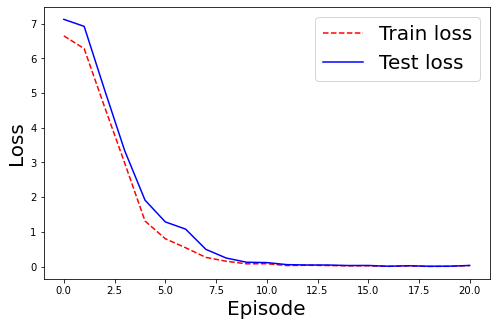

In [11]:
batch_size = 25
n_epochs = 2000
lr = 0.001

# Create data loaders for training and test data
train_loader = torch.utils.data.DataLoader(list(zip(torch.tensor(train_x).float(), torch.tensor(train_y).float())), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(torch.tensor(test_x).float(), torch.tensor(test_y).float())), batch_size=batch_size, shuffle=False)

# Create the neural network
net_width = 10
net_depth = 10
net_activation = 'tanh'

net = NeuralNetwork(width=net_width, depth=net_depth, activation=net_activation)
print('Total number of parameters:', sum(p.numel() for p in net.parameters())) #print total number of parameters
# print(net) #print the network architecture

# Define the loss function and the optimizer
loss_func = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train the network
net, train_loss, test_loss = train_network(net, train_loader, test_loader, n_epochs, optimizer, loss_func)

print('Final train loss:', train_loss[-1])
print('Final test loss:', test_loss[-1])

# Plot the training and test loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss[:-1], label='Train loss', linestyle='--', color='r')
plt.plot(test_loss[:-1], label='Test loss', linestyle='-', color='b')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Neural network -- evaluating the trained network

The following code cell:
* Creates a function which returns fully-connected neural network based on the user-specified width, depth and activation type.
* Initializes the neural network for training. 

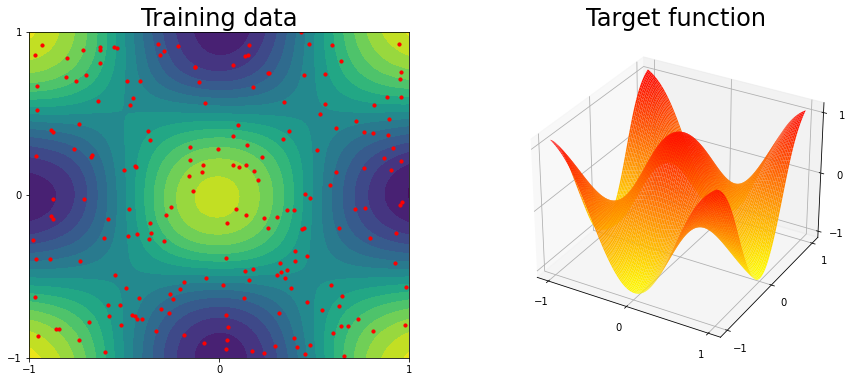

In [12]:
inputs = torch.tensor(np.hstack([X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)])).float()
with torch.no_grad():
    net.eval()
    predictions = net(inputs).numpy().reshape(100, 100)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,2,1)
ax.contourf(X_mesh, Y_mesh, predictions, 20)
ax.scatter(train_x[:,0], train_x[:,1], c='r', s=10)
ax.set_title(r'Training data', fontsize=24)
ax.xaxis.set_ticks([-1, 0, 1])
ax.yaxis.set_ticks([-1, 0, 1])
ax = fig.add_subplot(1,2,2, projection="3d")
ax.plot_surface(X_mesh, Y_mesh, predictions, cmap="autumn_r", lw=0.5, rstride=1, cstride=1)
ax.set_title(r'Target function', fontsize=24)
ax.xaxis.set_ticks([-1, 0, 1])
ax.yaxis.set_ticks([-1, 0, 1])
ax.zaxis.set_ticks([-1, 0, 1])
plt.show()

#### Learning exercise -- understanding the effect of increasing the width of the network and the effect of nonlinearity

Using the functions and program above, construct different instances of the network by fixing the network depth = 10 and varying the width of the network between $[2,5,10,15]$. Repeat this both with tanh and sin activations. 
* For each configuration, print total number of network parameters
* For a given choice of the activation function, what trends do you observe as you vary width?
* What effect does the choice of activation function appear to have?
* Do these trends vary if you re-run the script? What is the cause of this variation, if any?
* What is your conclusion about the expressivity of neural networks as a function of width and/or activation function?

Activation function: relu
Width: 25
Total number of parameters: 2701
Width: 100
Total number of parameters: 40801
Width: 200
Total number of parameters: 161601
Activation function: tanh
Width: 25
Total number of parameters: 2701
Width: 100
Total number of parameters: 40801
Width: 200
Total number of parameters: 161601


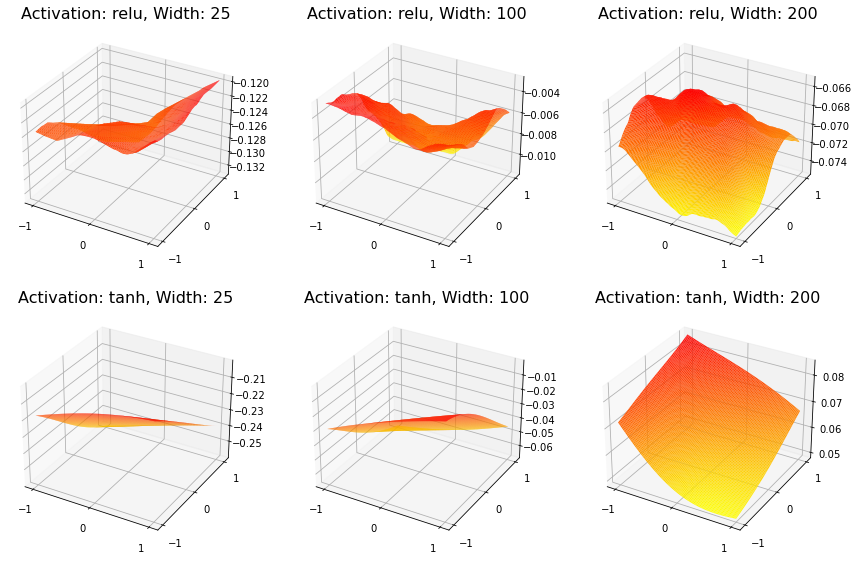

In [73]:
net_widths = [25, 100, 200]
net_depth = 5
net_activations = ['relu','tanh']

batch_size = 25
n_epochs = 2000
lr = 0.001

# Create data loaders for training and test data
train_loader = torch.utils.data.DataLoader(list(zip(torch.tensor(train_x).float(), torch.tensor(train_y).float())), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(torch.tensor(test_x).float(), torch.tensor(test_y).float())), batch_size=batch_size, shuffle=False)

# Define the loss function and the optimizer
# loss_func = torch.nn.MSELoss(reduction='sum')

predictions_list = []
inputs = torch.tensor(np.hstack([X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)])).float()  # Points over which to plot the predictions

for net_activation in net_activations:
    print('Activation function:', net_activation)
    for net_width in net_widths:
        print('Width:', net_width)
        net = NeuralNetwork(width=net_width, depth=net_depth, activation=net_activation)
        print('Total number of parameters:', sum(p.numel() for p in net.parameters())) #print total number of parameters
        #optimizer = torch.optim.Adam(net.parameters(), lr=lr)

        #net, _, _ = train_network(net, train_loader, test_loader, n_epochs, optimizer, loss_func, verbose=False)
        
        with torch.no_grad():
            net.eval()
            predictions = net(inputs).numpy().reshape(100, 100)
            predictions_list.append(predictions)

        del net #, optimizer



# Plot the predictions for different architectures
fig = plt.figure(figsize=(20, 20))
idx = 0
for i, net_activation in enumerate(net_activations):
    for j, net_width in enumerate(net_widths):
        ax = fig.add_subplot(4, 4, 4*i+j+1, projection="3d")
        #ax.contourf(X_mesh, Y_mesh, predictions_list[4*i+j], 20)
        ax.plot_surface(X_mesh, Y_mesh, predictions_list[idx], cmap="autumn_r", lw=0.5, rstride=1, cstride=1)
        ax.set_title(f'Activation: {net_activation}, Width: {net_width}', fontsize=16)
        ax.xaxis.set_ticks([-1, 0, 1])
        ax.yaxis.set_ticks([-1, 0, 1])
        idx += 1

